In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

# tokens to treat as missing
MISSING_TOKENS = ["?", "NA", "N/A", "", "null", "None", "none", "NULL", "NaN", "nan"]

def missing_summary(df):
    miss_count = df.isna().sum()
    miss_pct = (df.isna().mean() * 100).round(2)
    return (
        pd.DataFrame({"missing_count": miss_count, "missing_pct": miss_pct})
        .sort_values("missing_count", ascending=False)
    )

def clean_surface(df):
    """Strip headers + strip string cells + convert missing tokens to NaN."""
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()

    tokens_lower = {t.strip().lower() for t in MISSING_TOKENS}
    for c in df.columns:
        if pd.api.types.is_object_dtype(df[c]) or str(df[c].dtype) == "string":
            s = df[c].astype("string").str.strip()
            df[c] = s
            df.loc[df[c].str.lower().isin(tokens_lower), c] = np.nan
    return df

def smart_dedupe(df):
    """Drop duplicates using first ID-like column if present; otherwise full-row duplicates."""
    df = df.copy()
    id_cols = [c for c in df.columns if "id" in c.lower()]
    for c in id_cols:
        before = len(df)
        df = df.drop_duplicates(subset=[c], keep="first")
        if len(df) < before:
            return df
    return df.drop_duplicates()

def coerce_dates(df):
    """Convert columns with 'date' in name to datetime."""
    df = df.copy()
    for c in [c for c in df.columns if "date" in c.lower()]:
        df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def coerce_numerics_safe(df):
    """
    Fix numeric parsing:
    - score/rating columns: treat comma as decimal separator ("5,6" -> 5.6)
    - amount/price/cost/qty: treat comma as thousands separator ("3,500" -> 3500)
    """
    df = df.copy()
    for c in df.columns:
        cl = c.lower()

        numeric_hint = any(k in cl for k in [
            "amount", "sales", "price", "cost", "qty", "quantity", "score", "rating", "units"
        ])
        if not numeric_hint:
            continue

        s = df[c].astype("string").str.strip()

        if any(k in cl for k in ["score", "rating"]):
            s = s.str.replace(",", ".", regex=False)     # decimal comma
        else:
            s = s.str.replace(",", "", regex=False)      # thousands comma

        s = s.str.replace("₱", "", regex=False).str.replace("$", "", regex=False)
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

def standardize_categories(df):
    """Light cleaning for category-like columns."""
    df = df.copy()
    for c in df.select_dtypes(include=["object", "string"]).columns:
        df[c] = df[c].astype("string").str.strip()
    return df

def fill_missing_baseline(df):
    """Numeric -> median, Categorical -> mode (skip long free-text columns)."""
    df = df.copy()

    for c in df.select_dtypes(include=["number"]).columns:
        df[c] = df[c].fillna(df[c].median())

    skip_keywords = ["comment", "comments", "message", "review", "text", "description", "remarks", "notes"]
    for c in df.select_dtypes(include=["object", "string"]).columns:
        if any(k in c.lower() for k in skip_keywords):
            continue
        if df[c].isna().any():
            mode_val = df[c].mode(dropna=True)
            if len(mode_val) > 0:
                df[c] = df[c].fillna(mode_val.iloc[0])
    return df

def fix_1_to_10_scale(s):
    """
    If scores got inflated like 56 instead of 5.6, detect 11..100 and divide by 10.
    Then keep only 0..10 and fill missing with median.
    """
    s = pd.to_numeric(s, errors="coerce")
    mask = s.between(11, 100, inclusive="both")
    if mask.any():
        # if most of the bad values end in 0 (60, 70, 80), still divide by 10
        s.loc[mask] = s.loc[mask] / 10
    s = s.where((s >= 0) & (s <= 10), np.nan)
    return s.fillna(s.median())


In [2]:
transactions_raw = pd.read_csv("Transaction_Data.csv", dtype="string")
feedback_raw     = pd.read_csv("Customer_Feedback_Data.csv", dtype="string")
products_raw     = pd.read_csv("Product_Offering_Data.csv", dtype="string")

# strip headers immediately
for d in (transactions_raw, feedback_raw, products_raw):
    d.columns = d.columns.astype(str).str.strip()

print("RAW SHAPES")
print("Transactions:", transactions_raw.shape)
print("Feedback:    ", feedback_raw.shape)
print("Products:    ", products_raw.shape)

display(transactions_raw.head(3))
display(feedback_raw.head(3))
display(products_raw.head(3))


RAW SHAPES
Transactions: (5050, 5)
Feedback:     (5050, 4)
Products:     (15, 6)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type
0,1,393,2023-01-01 00:00:00,3472.0,Purchase
1,2,826,2023-01-01 01:00:00,<NA>,Bill Payment
2,3,916,2023-01-01 02:00:00,10.0,Purchase


,Customer_ID,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend
0,1,10.0,Very satisfied,9
1,2,3.0,Very satisfied,3
2,3,10.0,Very satisfied,1


,Product_ID,Product_Name,Product_Type,Risk_Level,Target_Age_Group,Target_Income_Group
0,1,Platinum Credit Card,Credit Card,Medium,<NA>,Medium
1,2,Gold Savings Account,Savings Account,Low,<NA>,Low
2,3,High-Yield Investment Account,Investment,High,<NA>,High


In [3]:
def clean_pipeline(df):
    df = clean_surface(df)
    df = smart_dedupe(df)
    df = coerce_dates(df)
    df = coerce_numerics_safe(df)
    df = standardize_categories(df)
    return df

transactions = clean_pipeline(transactions_raw)
feedback     = clean_pipeline(feedback_raw)
products     = clean_pipeline(products_raw)

# dataset-specific fixes
if "Transaction_Amount" in transactions.columns:
    transactions["Amount_Was_Missing"] = transactions["Transaction_Amount"].isna()
    if "Transaction_Type" in transactions.columns:
        med_by_type = transactions.groupby("Transaction_Type")["Transaction_Amount"].median()
        transactions["Transaction_Amount"] = transactions["Transaction_Amount"].fillna(
            transactions["Transaction_Type"].map(med_by_type)
        )
    transactions["Transaction_Amount"] = transactions["Transaction_Amount"].fillna(
        transactions["Transaction_Amount"].median()
    )

for col in ["Satisfaction_Score", "Likelihood_to_Recommend"]:
    if col in feedback.columns:
        feedback[col] = fix_1_to_10_scale(feedback[col])

# baseline fill remaining
transactions = fill_missing_baseline(transactions)
feedback     = fill_missing_baseline(feedback)
products     = fill_missing_baseline(products)

print("CLEANED SHAPES")
print("Transactions:", transactions.shape)
print("Feedback:    ", feedback.shape)
print("Products:    ", products.shape)

print("\nTOP MISSING - Transactions")
display(missing_summary(transactions).head(10))
print("\nTOP MISSING - Feedback")
display(missing_summary(feedback).head(10))
print("\nTOP MISSING - Products")
display(missing_summary(products).head(10))


CLEANED SHAPES
Transactions: (5000, 6)
Feedback:     (1000, 4)
Products:     (10, 6)

TOP MISSING - Transactions


,missing_count,missing_pct
Transaction_ID,0,0.0
Customer_ID,0,0.0
Transaction_Date,0,0.0
Transaction_Amount,0,0.0
Transaction_Type,0,0.0
Amount_Was_Missing,0,0.0



TOP MISSING - Feedback


,missing_count,missing_pct
Customer_ID,0,0.0
Satisfaction_Score,0,0.0
Feedback_Comments,0,0.0
Likelihood_to_Recommend,0,0.0



TOP MISSING - Products


,missing_count,missing_pct
Target_Age_Group,10,100.0
Product_ID,0,0.0
Product_Name,0,0.0
Product_Type,0,0.0
Risk_Level,0,0.0
Target_Income_Group,0,0.0


In [4]:
merged = transactions.copy()

# Merge feedback (try Customer_ID)
if "Customer_ID" in merged.columns and "Customer_ID" in feedback.columns:
    merged = merged.merge(feedback, on="Customer_ID", how="left", suffixes=("_tx", "_fb"))
else:
    print("NOTE: Customer_ID not found in BOTH transactions and feedback -> skipping feedback merge.")

# Merge products (try Product_ID, else Product_Name)
if "Product_ID" in merged.columns and "Product_ID" in products.columns:
    merged = merged.merge(products, on="Product_ID", how="left", suffixes=("", "_prod"))
elif "Product_Name" in merged.columns and "Product_Name" in products.columns:
    merged = merged.merge(products, on="Product_Name", how="left", suffixes=("", "_prod"))
else:
    print("NOTE: No shared product key found -> skipping products merge.")

final_df = merged.copy()

# basic sanity filters
if "Transaction_Date" in final_df.columns:
    final_df["Transaction_Date"] = pd.to_datetime(final_df["Transaction_Date"], errors="coerce")
    final_df = final_df[final_df["Transaction_Date"].notna()].copy()

if "Transaction_Amount" in final_df.columns and pd.api.types.is_numeric_dtype(final_df["Transaction_Amount"]):
    final_df = final_df[final_df["Transaction_Amount"] >= 0].copy()

print("FINAL DATASET SHAPE:", final_df.shape)
display(final_df.head())

# Confirm score ranges if present
for col in ["Satisfaction_Score", "Likelihood_to_Recommend"]:
    if col in final_df.columns:
        print(f"{col} min/max:", final_df[col].min(), final_df[col].max())


NOTE: No shared product key found -> skipping products merge.
FINAL DATASET SHAPE: (5000, 9)


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type,Amount_Was_Missing,Satisfaction_Score,Feedback_Comments,Likelihood_to_Recommend
0,1,393,2023-01-01 00:00:00,3472.0,Purchase,False,1.0,Excellent,3
1,2,826,2023-01-01 01:00:00,2485.0,Bill Payment,True,5.4,Needs improvement,3
2,3,916,2023-01-01 02:00:00,10.0,Purchase,False,6.0,Needs improvement,3
3,4,109,2023-01-01 03:00:00,72.0,Investment,False,3.0,Good service,9
4,5,889,2023-01-01 04:00:00,1793.0,Investment,False,8.0,Very satisfied,3


Satisfaction_Score min/max: 1.0 10.0
Likelihood_to_Recommend min/max: 1 10


Explained Variance Ratio: [0.26546977 0.15243173]
Total Explained Variance (PC1+PC2): 0.4179015044508463


,PC1,PC2
0,2.211604,0.261014
1,2.193498,1.261989
2,2.208892,1.351749
3,2.191301,-0.454023
4,2.211842,1.834097



Top contributors to PC1 (absolute):


Is_Weekend                       0.707016
DayOfWeek                        0.706942
Transaction_Type_Bill Payment    0.011871
Likelihood_to_Recommend          0.010776
Transaction_Type_Investment      0.007827
Month                            0.004983
Transaction_Type_Purchase        0.003954
Satisfaction_Score               0.001400
Transaction_Amount               0.000752
Transaction_Type_Loan Payment    0.000090
Name: PC1_loading, dtype: float64


Top contributors to PC2 (absolute):


Satisfaction_Score               0.617976
Month                            0.556820
Likelihood_to_Recommend          0.541483
Transaction_Amount               0.120062
Transaction_Type_Purchase        0.015601
DayOfWeek                        0.009522
Transaction_Type_Bill Payment    0.008754
Transaction_Type_Investment      0.004655
Transaction_Type_Loan Payment    0.002192
Is_Weekend                       0.001378
Name: PC2_loading, dtype: float64

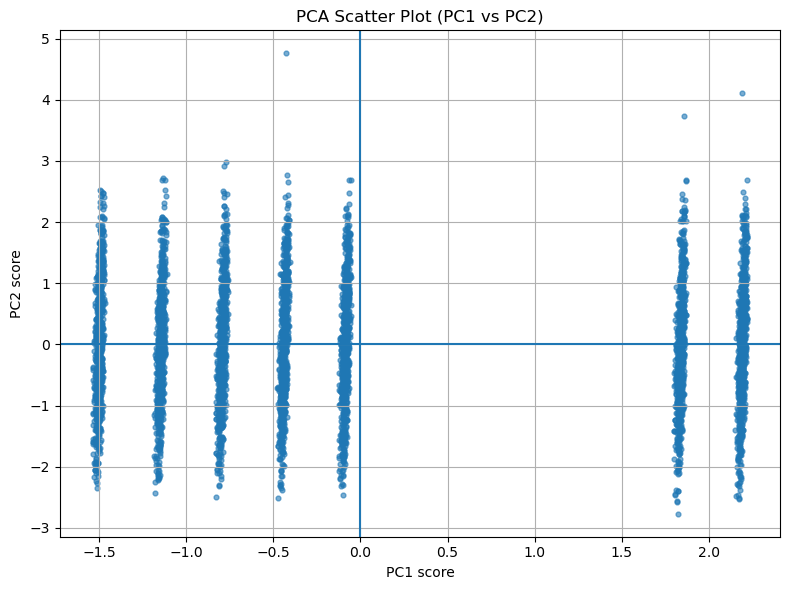

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = final_df.copy()

# --- choose PCA features ---
features = []

# numeric features
for c in ["Transaction_Amount", "Satisfaction_Score", "Likelihood_to_Recommend"]:
    if c in df.columns:
        features.append(c)

# optional categorical
for c in ["Transaction_Type"]:
    if c in df.columns:
        features.append(c)

# optional time-derived numeric features
if "Transaction_Date" in df.columns:
    df["Month"] = df["Transaction_Date"].dt.month
    df["DayOfWeek"] = df["Transaction_Date"].dt.dayofweek
    df["Is_Weekend"] = (df["DayOfWeek"] >= 5).astype(int)
    features += ["Month", "DayOfWeek", "Is_Weekend"]

df_pca = df[features].copy()

# split numeric vs categorical
numeric_cols = df_pca.select_dtypes(include=["number", "bool", "int64", "float64"]).columns.tolist()
categorical_cols = [c for c in df_pca.columns if c not in numeric_cols]

# OneHotEncoder (works across sklearn versions)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", ohe, categorical_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X = preprocess.fit_transform(df_pca)

# feature names for loadings
try:
    all_feature_names = preprocess.get_feature_names_out()
except Exception:
    all_feature_names = np.array([f"feature_{i}" for i in range(X.shape[1])])

# --- PCA ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_scores_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance (PC1+PC2):", pca.explained_variance_ratio_.sum())
display(pca_scores_df.head())

# --- loadings (what drives PC1/PC2) ---
pc1 = pd.Series(pca.components_[0], index=all_feature_names, name="PC1_loading")
pc2 = pd.Series(pca.components_[1], index=all_feature_names, name="PC2_loading")

print("\nTop contributors to PC1 (absolute):")
display(pc1.abs().sort_values(ascending=False).head(12))

print("\nTop contributors to PC2 (absolute):")
display(pc2.abs().sort_values(ascending=False).head(12))

# --- PCA scatter plot ---
plt.figure(figsize=(8, 6))
plt.scatter(pca_scores_df["PC1"], pca_scores_df["PC2"], s=12, alpha=0.6)
plt.axhline(0)
plt.axvline(0)
plt.title("PCA Scatter Plot (PC1 vs PC2)")
plt.xlabel("PC1 score")
plt.ylabel("PC2 score")
plt.grid(True)
plt.tight_layout()
plt.show()


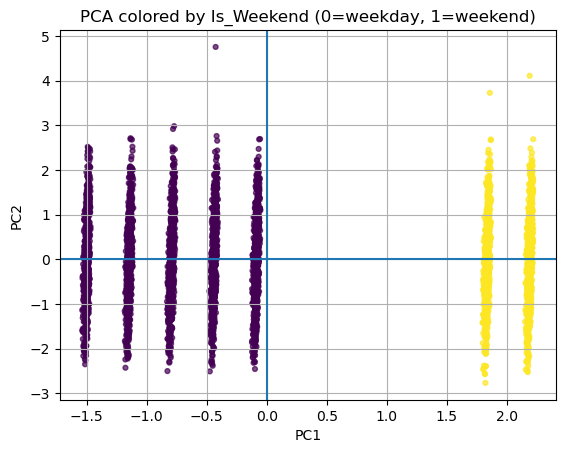

In [6]:
plt.figure()
plt.scatter(pca_scores_df["PC1"], pca_scores_df["PC2"], c=df_pca.get("Is_Weekend", 0), s=12, alpha=0.7)
plt.axhline(0); plt.axvline(0)
plt.title("PCA colored by Is_Weekend (0=weekday, 1=weekend)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()


Explained Variance Ratio: [0.27096676 0.26953477]
Total Explained Variance: 0.5405015313813363


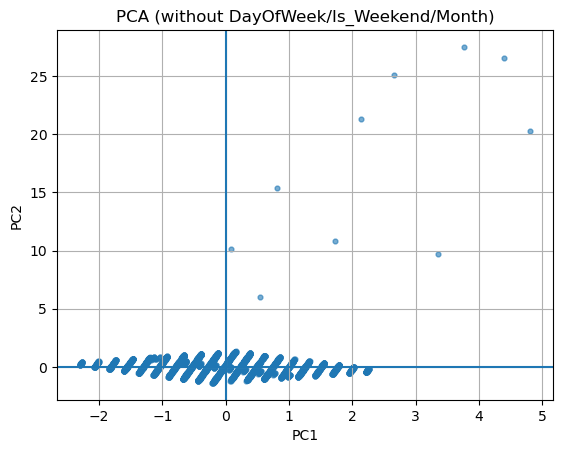

In [7]:
features_no_time = []
for c in ["Transaction_Amount", "Satisfaction_Score", "Likelihood_to_Recommend", "Transaction_Type"]:
    if c in df.columns:
        features_no_time.append(c)

df_pca2 = df[features_no_time].copy()

numeric_cols2 = df_pca2.select_dtypes(include=["number", "bool", "int64", "float64"]).columns.tolist()
categorical_cols2 = [c for c in df_pca2.columns if c not in numeric_cols2]

try:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe2 = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols2),
        ("cat", ohe2, categorical_cols2)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X2 = preprocess2.fit_transform(df_pca2)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X2)

print("Explained Variance Ratio:", pca2.explained_variance_ratio_)
print("Total Explained Variance:", pca2.explained_variance_ratio_.sum())

plt.figure()
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=12, alpha=0.6)
plt.axhline(0); plt.axvline(0)
plt.title("PCA (without DayOfWeek/Is_Weekend/Month)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [8]:
import numpy as np
import pandas as pd

df = final_df.copy()

# --- required columns check (won't crash if some are missing) ---
key_cols = ["Customer_ID", "Transaction_Date", "Transaction_Amount", "Transaction_Type",
            "Satisfaction_Score", "Likelihood_to_Recommend"]
print("Columns present:", [c for c in key_cols if c in df.columns])

# Ensure date + numeric
if "Transaction_Date" in df.columns:
    df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"], errors="coerce")

if "Transaction_Amount" in df.columns:
    df["Transaction_Amount"] = pd.to_numeric(df["Transaction_Amount"], errors="coerce")

for c in ["Satisfaction_Score", "Likelihood_to_Recommend"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- 1) Customer-level core metrics (RFM-ish + satisfaction) ---
# Reference date = most recent transaction date in dataset
ref_date = df["Transaction_Date"].max() if "Transaction_Date" in df.columns else None

g = df.groupby("Customer_ID", dropna=True)

customer = pd.DataFrame(index=g.size().index)

customer["n_tx"] = g.size()

if "Transaction_Amount" in df.columns:
    customer["total_spend"] = g["Transaction_Amount"].sum(min_count=1)
    customer["avg_amount"]  = g["Transaction_Amount"].mean()

if ref_date is not None:
    last_date = g["Transaction_Date"].max()
    customer["recency_days"] = (ref_date - last_date).dt.days

if "Satisfaction_Score" in df.columns:
    customer["sat_mean"] = g["Satisfaction_Score"].mean()

if "Likelihood_to_Recommend" in df.columns:
    customer["ltr_mean"] = g["Likelihood_to_Recommend"].mean()

# --- 2) Transaction type mix (percent of each type per customer) ---
if "Transaction_Type" in df.columns:
    type_counts = (
        df.pivot_table(index="Customer_ID", columns="Transaction_Type",
                       values="Transaction_Amount", aggfunc="size", fill_value=0)
    )
    type_share = type_counts.div(type_counts.sum(axis=1), axis=0)
    # keep only top types to avoid too many columns
    top_types = type_counts.sum(axis=0).sort_values(ascending=False).head(6).index
    type_share = type_share[top_types]
    type_share.columns = [f"type_share_{c}" for c in type_share.columns]
    customer = customer.join(type_share, how="left")

# --- 3) Fill missing values (simple, explainable) ---
for c in customer.columns:
    if customer[c].dtype.kind in "biufc":
        customer[c] = customer[c].fillna(customer[c].median())
    else:
        customer[c] = customer[c].fillna(0)

customer_df = customer.reset_index()
display(customer_df.head())
print("customer_df shape:", customer_df.shape)


Columns present: ['Customer_ID', 'Transaction_Date', 'Transaction_Amount', 'Transaction_Type', 'Satisfaction_Score', 'Likelihood_to_Recommend']


,Customer_ID,n_tx,total_spend,avg_amount,recency_days,sat_mean,ltr_mean,type_share_Loan Payment,type_share_Investment,type_share_Bill Payment,type_share_Purchase
0,1,6,16836.0,2806.0,26,10.0,9.0,0.166667,0.166667,0.50,0.166667
1,10,6,15682.0,2613.666667,5,7.0,1.0,0.000000,0.166667,0.50,0.333333
2,100,4,5850.0,1462.5,8,7.0,5.0,0.250000,0.250000,0.25,0.250000
3,1000,6,9652.0,1608.666667,37,5.0,10.0,0.500000,0.333333,0.00,0.166667
4,101,1,1552.0,1552.0,139,6.0,6.0,0.000000,1.000000,0.00,0.000000


customer_df shape: (993, 11)


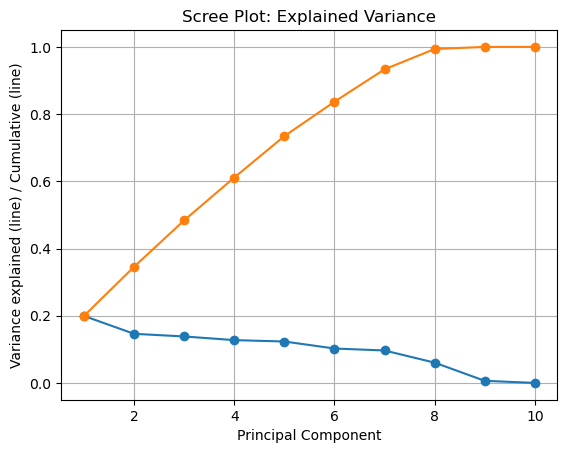

Explained variance first 2 PCs: [0.19941105 0.1461252 ] Total: 0.3455362527829546


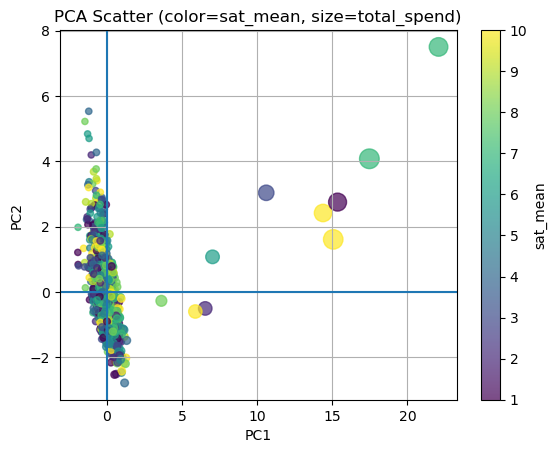

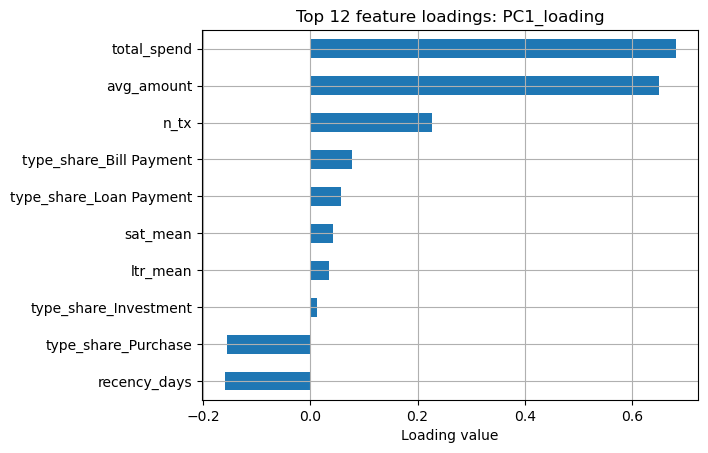

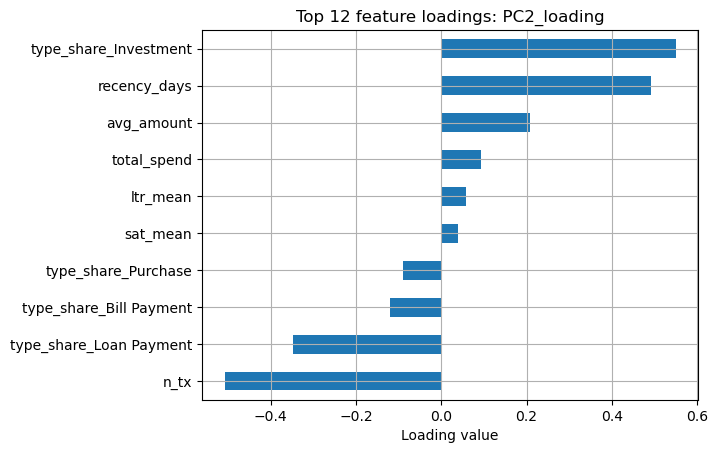

,PC1_loading,PC2_loading
total_spend,0.680692,0.093212
avg_amount,0.650467,0.206957
n_tx,0.226765,-0.507632
recency_days,-0.159684,0.491464
type_share_Purchase,-0.156083,-0.090081
type_share_Bill Payment,0.077558,-0.119274
type_share_Loan Payment,0.056567,-0.347617
sat_mean,0.041343,0.038030
ltr_mean,0.034507,0.058588
type_share_Investment,0.012364,0.548813


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------------------------
# 1) Build X for PCA
# -------------------------
pca_data = customer_df.copy()

# Choose features (edit if you want, but this set is usually strong)
feature_cols = [c for c in pca_data.columns if c not in ["Customer_ID"]]

# Keep only numeric
X_df = pca_data[feature_cols].select_dtypes(include=[np.number]).copy()

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(X_df)

# -------------------------
# 2) Fit PCA (10 comps for scree)
# -------------------------
pca_full = PCA(n_components=min(10, X.shape[1]), random_state=42)
X_full = pca_full.fit_transform(X)

evr = pca_full.explained_variance_ratio_
cum = np.cumsum(evr)

# -------------------------
# PLOT 1: Scree plot
# -------------------------
plt.figure()
plt.plot(range(1, len(evr)+1), evr, marker="o")
plt.plot(range(1, len(cum)+1), cum, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Variance explained (line) / Cumulative (line)")
plt.title("Scree Plot: Explained Variance")
plt.grid(True)
plt.show()

print("Explained variance first 2 PCs:", evr[:2], "Total:", evr[:2].sum())

# -------------------------
# 3) 2D PCA for the key scatter plot
# -------------------------
pca_2 = PCA(n_components=2, random_state=42)
X_2 = pca_2.fit_transform(X)

scores = pd.DataFrame(X_2, columns=["PC1", "PC2"])
scores["Customer_ID"] = pca_data["Customer_ID"].values

# Keep useful business overlay columns if they exist
for col in ["sat_mean", "total_spend", "n_tx"]:
    if col in pca_data.columns:
        scores[col] = pca_data[col].values

# -------------------------
# PLOT 2: PCA Scatter (color = satisfaction, size = spend)
# -------------------------
plt.figure()

# Color choice: satisfaction if available, else total_spend, else n_tx
color_col = "sat_mean" if "sat_mean" in scores.columns else ("total_spend" if "total_spend" in scores.columns else "n_tx")
c = scores[color_col]

# Size: total_spend if available, else n_tx
if "total_spend" in scores.columns:
    s = (scores["total_spend"] - scores["total_spend"].min()) / (scores["total_spend"].max() - scores["total_spend"].min() + 1e-9)
    s = 20 + 180*s
else:
    s = 30

sc = plt.scatter(scores["PC1"], scores["PC2"], c=c, s=s, alpha=0.7)
plt.axhline(0)
plt.axvline(0)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"PCA Scatter (color={color_col}, size={'total_spend' if 'total_spend' in scores.columns else 'n_tx'})")
plt.grid(True)
plt.colorbar(sc, label=color_col)
plt.show()

# -------------------------
# PLOT 3: Loadings (Top drivers for PC1 and PC2)
# -------------------------
loadings = pd.DataFrame(
    pca_2.components_.T,
    index=X_df.columns,
    columns=["PC1_loading", "PC2_loading"]
)

def plot_top_loadings(col, top_n=10):
    top = loadings[col].abs().sort_values(ascending=False).head(top_n).index
    plt.figure()
    loadings.loc[top, col].sort_values().plot(kind="barh")
    plt.title(f"Top {top_n} feature loadings: {col}")
    plt.xlabel("Loading value")
    plt.grid(True)
    plt.show()

plot_top_loadings("PC1_loading", top_n=12)
plot_top_loadings("PC2_loading", top_n=12)

display(loadings.reindex(loadings["PC1_loading"].abs().sort_values(ascending=False).head(12).index))


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

df = final_df.copy()

def pick_col(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

COL_DATE  = pick_col(["Transaction_Date", "Date", "transaction_date"])
COL_AMT   = pick_col(["Transaction_Amount", "Amount", "Sales_Amount"])
COL_TYPE  = pick_col(["Transaction_Type", "Type", "transaction_type"])
COL_SCORE = pick_col(["Satisfaction_Score", "Satisfaction", "Score"])
COL_RECO  = pick_col(["Likelihood_to_Recommend", "Recommend_Score", "NPS_Likelihood"])

print("Detected:", {"DATE":COL_DATE,"AMOUNT":COL_AMT,"TYPE":COL_TYPE,"SAT":COL_SCORE,"RECO":COL_RECO})

if COL_DATE: df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors="coerce")
for c in [COL_AMT, COL_SCORE, COL_RECO]:
    if c: df[c] = pd.to_numeric(df[c], errors="coerce")


Detected: {'DATE': 'Transaction_Date', 'AMOUNT': 'Transaction_Amount', 'TYPE': 'Transaction_Type', 'SAT': 'Satisfaction_Score', 'RECO': 'Likelihood_to_Recommend'}


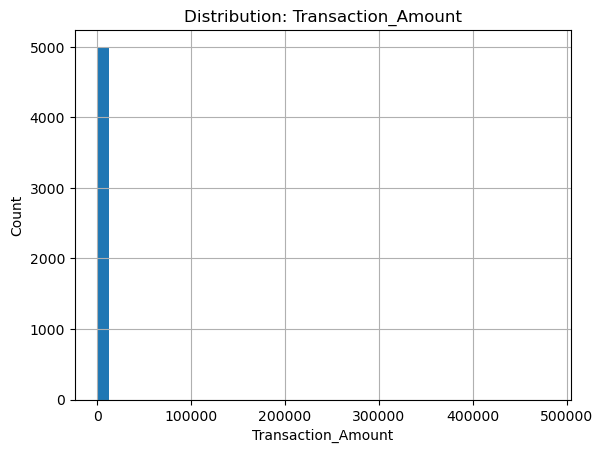

,count,mean,std,min,25%,50%,75%,max
Transaction_Amount,5000.0,3089.6567,14743.713748,10.0,1260.0,2485.0,3682.0,480300.0


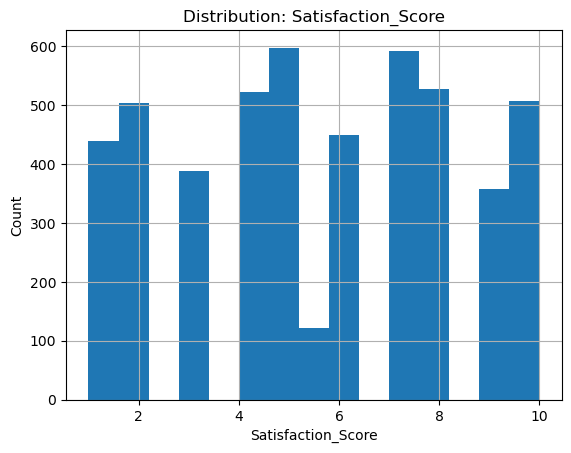

,count,mean,std,min,25%,50%,75%,max
Satisfaction_Score,5000.0,5.53244,2.761737,1.0,3.0,5.4,8.0,10.0


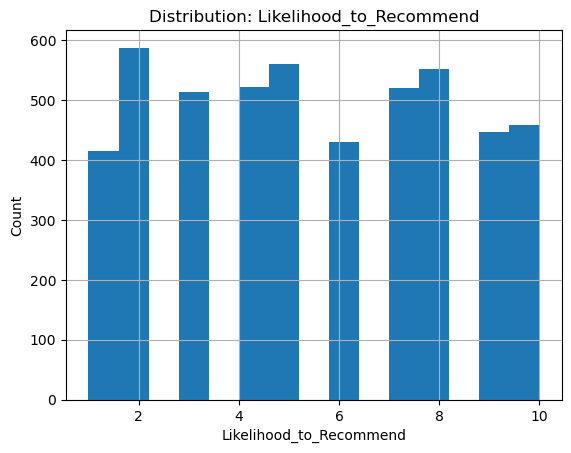

,count,mean,std,min,25%,50%,75%,max
Likelihood_to_Recommend,5000.0,5.4472,2.812756,1.0,3.0,5.0,8.0,10.0


In [13]:
def quick_hist(col, bins=30):
    if not col:
        return
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"Skipping {col}: no numeric values.")
        return
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.grid(True)
    plt.show()
    display(s.describe().to_frame(col).T)

quick_hist(COL_AMT, bins=40)
quick_hist(COL_SCORE, bins=15)
quick_hist(COL_RECO, bins=15)


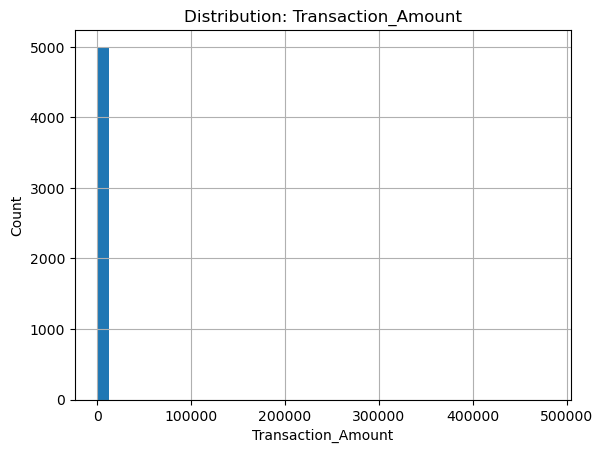

,count,mean,std,min,25%,50%,75%,max
Transaction_Amount,5000.0,3089.6567,14743.713748,10.0,1260.0,2485.0,3682.0,480300.0


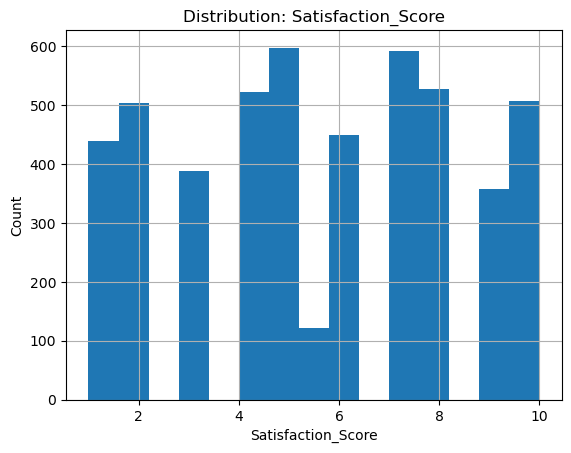

,count,mean,std,min,25%,50%,75%,max
Satisfaction_Score,5000.0,5.53244,2.761737,1.0,3.0,5.4,8.0,10.0


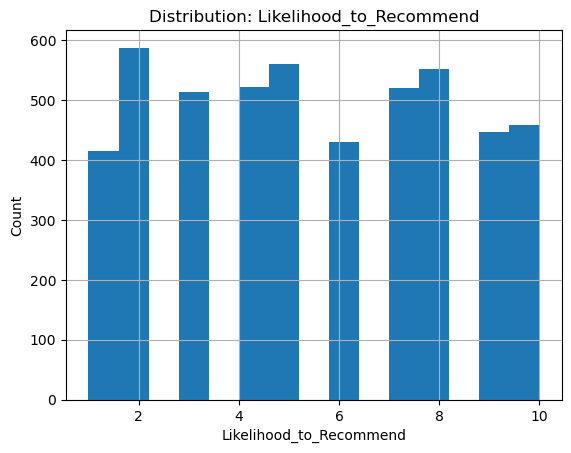

,count,mean,std,min,25%,50%,75%,max
Likelihood_to_Recommend,5000.0,5.4472,2.812756,1.0,3.0,5.0,8.0,10.0


In [14]:
def quick_hist(col, bins=30):
    if not col:
        return
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"Skipping {col}: no numeric values.")
        return
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.grid(True)
    plt.show()
    display(s.describe().to_frame(col).T)

quick_hist(COL_AMT, bins=40)
quick_hist(COL_SCORE, bins=15)
quick_hist(COL_RECO, bins=15)


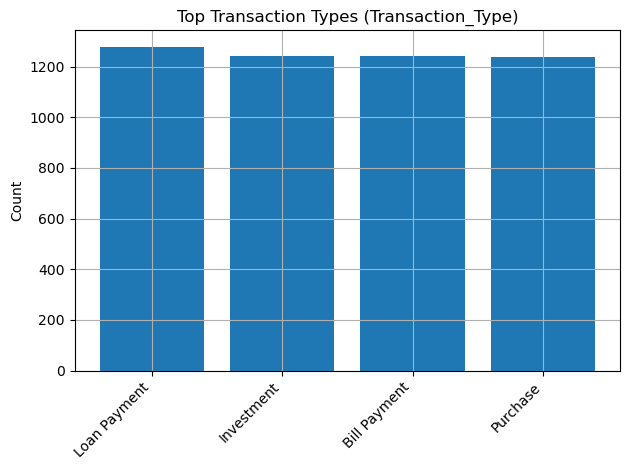

,count
Transaction_Type,
Loan Payment,1279
Investment,1243
Bill Payment,1241
Purchase,1237


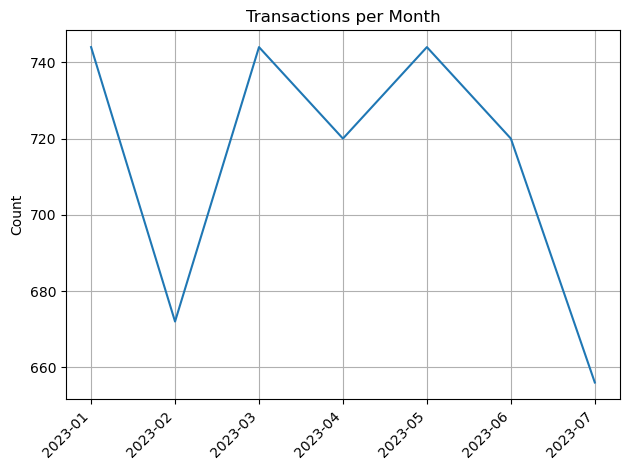

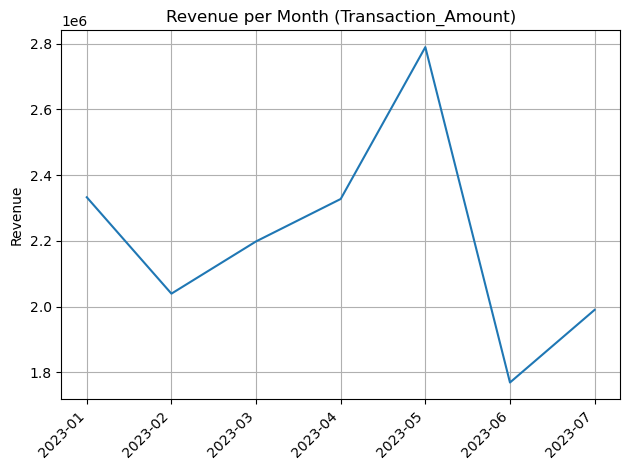

In [15]:
# Transaction mix
if COL_TYPE:
    vc = df[COL_TYPE].astype("string").str.strip().value_counts().head(10)
    plt.figure()
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top Transaction Types ({COL_TYPE})")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    display(vc.to_frame("count"))

# Time trend
if COL_DATE:
    dft = df[df[COL_DATE].notna()].copy()
    dft["month"] = dft[COL_DATE].dt.to_period("M").astype(str)

    monthly_count = dft.groupby("month").size()
    plt.figure()
    plt.plot(monthly_count.index, monthly_count.values)
    plt.title("Transactions per Month")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    if COL_AMT:
        monthly_rev = dft.groupby("month")[COL_AMT].sum()
        plt.figure()
        plt.plot(monthly_rev.index, monthly_rev.values)
        plt.title(f"Revenue per Month ({COL_AMT})")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Revenue")
        plt.tight_layout()
        plt.grid(True)
        plt.show()


,count,mean,median
Transaction_Type,,,
Investment,1243,5.622204,5.4
Loan Payment,1279,5.533385,5.4
Bill Payment,1241,5.487027,5.4
Purchase,1237,5.486823,5.0


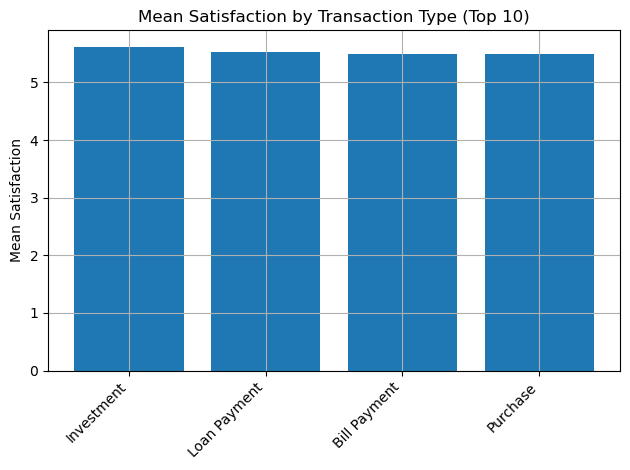

,count,mean,median
Spend_Bin,,,
"(9.999, 1023.8]",1000,5.6808,6.0
"(1023.8, 2006.8]",1000,5.546,5.4
"(2006.8, 2948.4]",1000,5.4396,5.0
"(2948.4, 3954.0]",1001,5.526673,5.4
"(3954.0, 480300.0]",999,5.469069,5.4


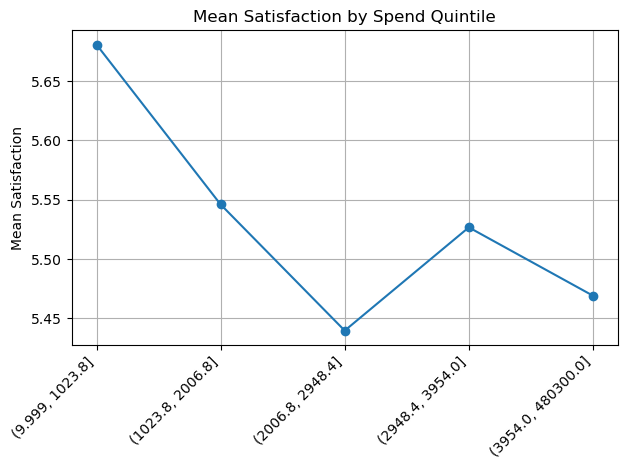

In [17]:
# Satisfaction by transaction type
if COL_SCORE and COL_TYPE:
    tmp = df[[COL_TYPE, COL_SCORE]].dropna().copy()
    by_type = tmp.groupby(COL_TYPE)[COL_SCORE].agg(["count","mean","median"]).sort_values("mean", ascending=False)
    display(by_type.head(12))

    top = by_type.head(10)
    plt.figure()
    plt.bar(top.index.astype(str), top["mean"].values)
    plt.title("Mean Satisfaction by Transaction Type (Top 10)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Mean Satisfaction")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Satisfaction by spend level (quintiles)
if COL_SCORE and COL_AMT:
    tmp = df[[COL_AMT, COL_SCORE]].dropna().copy()
    if len(tmp) > 0:
        tmp["Spend_Bin"] = pd.qcut(tmp[COL_AMT], q=5, duplicates="drop")
        by_bin = tmp.groupby("Spend_Bin", observed=True)[COL_SCORE].agg(["count","mean","median"])
        display(by_bin)

        plt.figure()
        plt.plot(by_bin.index.astype(str), by_bin["mean"].values, marker="o")
        plt.title("Mean Satisfaction by Spend Quintile")
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Mean Satisfaction")
        plt.tight_layout()
        plt.grid(True)
        plt.show()
